In [1]:
import os
import sys
from pathlib import Path
django_project_dir = Path(".")
sys.path.insert(0, str(django_project_dir))
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "newsilkroad.settings")
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
import django
django.setup()

[raven.contrib.django.client.DjangoClient]DEBUG 21:28:52 Configuring Raven for host: None
[raven.contrib.django.client.DjangoClient]INFO 21:28:52 Raven is not configured (logging is disabled). Please see the documentation for more information.


In [10]:
import pandas as pd
import geopandas
import matplotlib
from shapely.geometry import Point
import matplotlib.pyplot as plt

from django.db import connection

from infrastructure.models import Project
from locations.models import GeometryStore

## Asia

<AxesSubplot:>

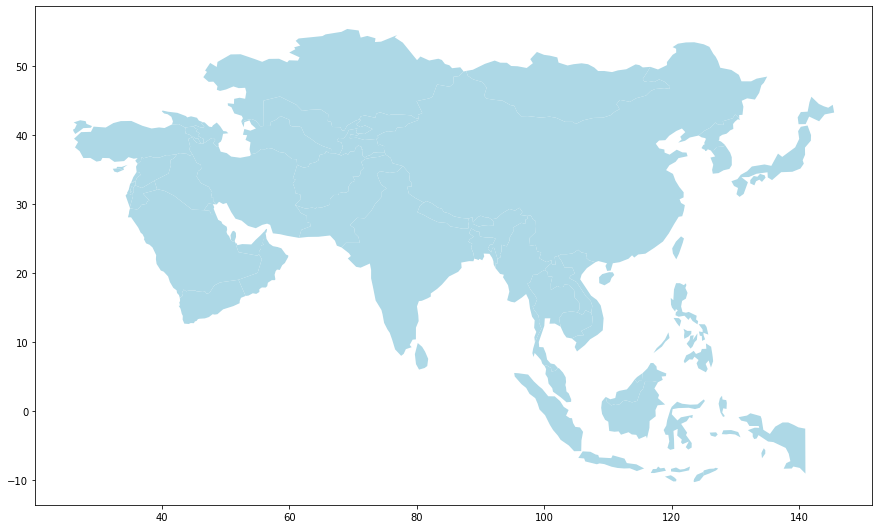

In [28]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
asia = world[world.continent == 'Asia']
asia.plot(figsize=(15,10), color='lightblue')

# Project Centroids

In [29]:
df = pd.DataFrame(Project.objects.values("identifier", "geo__centroid"))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14175 entries, 0 to 14174
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   identifier     14175 non-null  object
 1   geo__centroid  9447 non-null   object
dtypes: object(2)
memory usage: 221.6+ KB


In [30]:
# convert geo__centroid to Point
df["centroid"] = df['geo__centroid'].dropna().apply(Point)

In [32]:
# convert to GeoDataFrame using centroid column as geometry
df = geopandas.GeoDataFrame(df, geometry='centroid')
df.head()

,identifier,geo__centroid,centroid
0,dbf32433-5c1a-45ef-8b01-f9b4d14ec14a,None,None
1,61c2e46e-143b-44de-8603-245d7df6f222,"[69.38632282172752, 35.0225749028977]",POINT (69.38632 35.02257)
2,8c99867a-0021-4883-a2b3-b24e54d5f294,"[68.7531764137017, 33.68524636471736]",POINT (68.75318 33.68525)
3,537ffe47-9cb6-4293-9b96-9db5fecf677e,"[67.14828420467336, 35.28156348223486]",POINT (67.14828 35.28156)
4,5021b5b0-4c8f-444d-a14c-7da795cdfb8f,"[71.31405183898606, 36.957085267575174]",POINT (71.31405 36.95709)


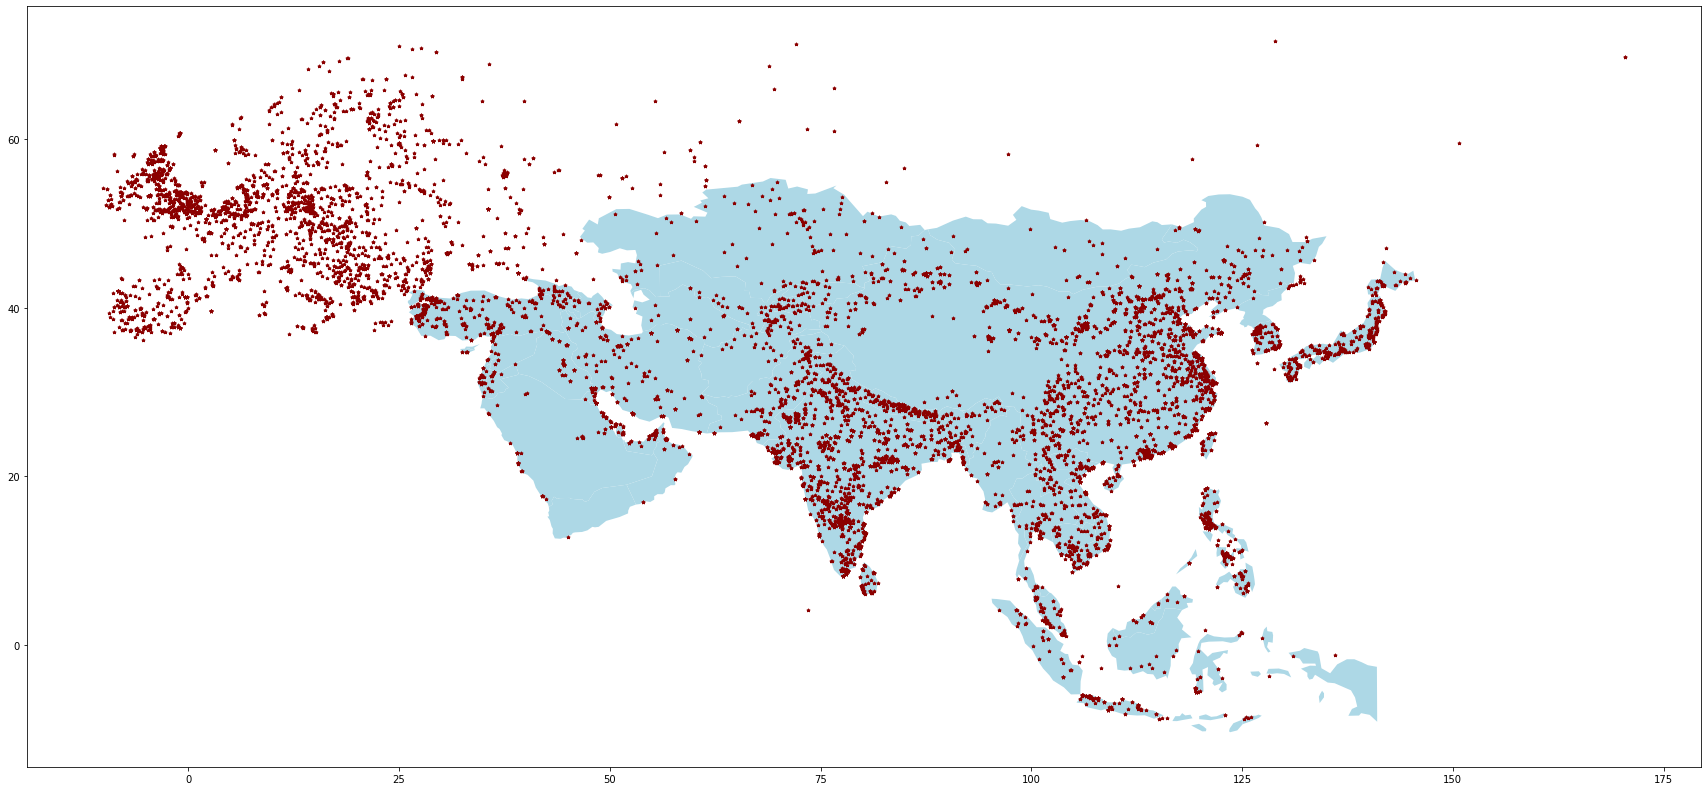

In [33]:
# create base plot with asia
fig, ax = plt.subplots(1, figsize=(30,20))
base = asia.plot(ax=ax, color='lightblue')

# plot cenroids on top with red color to stand out
df.plot(ax=base, color='darkred', marker="*", markersize=10);

# infrastructure_projects_export_view

In [34]:
with connection.cursor() as cursor:
    projects = pd.read_sql("SELECT * FROM infrastructure_projects_export_view;", connection)

In [35]:
projects.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14175 entries, 0 to 14174
Data columns (total 61 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   identifier                     14175 non-null  object 
 1   name                           14175 non-null  object 
 2   infrastructure_type            14169 non-null  object 
 3   countries                      14172 non-null  object 
 4   regions                        14120 non-null  object 
 5   contractors                    3959 non-null   object 
 6   initiatives                    1156 non-null   object 
 7   operators                      754 non-null    object 
 8   funding_sources                1547 non-null   object 
 9   funding_amounts                1547 non-null   object 
 10  funding_currencies             1547 non-null   object 
 11  fuel_type                      10970 non-null  object 
 12  fuel_category                  10970 non-null 